In [1]:
import os
import numpy as np
import pandas as pd
import random
import warnings
from tabulate import tabulate

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Dot, Flatten, Concatenate, Add
from sklearn.model_selection import train_test_split

In [4]:
!pip install sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 53.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 66.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 34.9 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=7838b306cb0bd6203c6ec1bfa0b6226b74528b32f01d9458ba2609008f5034f7
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [2]:
import tensorflow as tf

print("TensorFlow version: " + tf.__version__)

TensorFlow version: 2.13.0


In [5]:
from sentence_transformers import SentenceTransformer

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'pdf.fonttype': 'truetype'})
warnings.simplefilter("ignore")

In [6]:
#
# Helper functions
#
def print_df(df, col_width = 10, rows = 10, max_cols = 10):
    def short_srt(x):
        return x if len(x) < col_width else x[:col_width-3] + "..."
    df_short = df.head(rows).applymap(lambda x: short_srt(str(x)))

    if len(df_short.columns) > max_cols:
        df_short = df_short.iloc[:, 0:max_cols-1]
        df_short['...'] = '...'

    print(tabulate(df_short, headers='keys', tablefmt='psql'))
    print(f'{len(df)} rows x {len(df.columns)} columns')

def plot_keras_training_hitory(history):
    plt.plot(history.history['loss']);
    plt.plot(history.history['val_loss']);
    plt.xlabel('Training epoch')
    plt.ylabel('Loss')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.grid(True)

## Load Data

Load movie ratings and tags from the MovieLens 10M dataset.

In [11]:
from google.colab import drive
import io
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Specify the folder name
folder_name = 'ADM_Presentation'

# Define the file names
movies_csv_filename = 'movies.csv'
ratings_csv_filename = 'ratings.csv'
tags_csv_filename = 'tags.csv'

# Construct the full paths to the CSV files
movies_csv_path = f'/content/drive/My Drive/{folder_name}/{movies_csv_filename}'
ratings_csv_path = f'/content/drive/My Drive/{folder_name}/{ratings_csv_filename}'
tags_csv_path = f'/content/drive/My Drive/{folder_name}/{tags_csv_filename}'

# Read the uploaded CSV files
items = pd.read_csv(movies_csv_path, skiprows=1, names=['item_id', 'title', 'genres'])
ratings = pd.read_csv(ratings_csv_path, skiprows=1, names=['user_id', 'item_id', 'rating', 'timestamp'])
tags = pd.read_csv(tags_csv_path, skiprows=1, names=['user_id', 'item_id', 'tag', 'timestamp'])

# Rest of your code remains the same.
# You can continue with the rest of your data processing logic.

#
# Concatenate tags
#
tags_flat = tags[['item_id', 'tag']]\
    .groupby(by=['item_id'])['tag']\
    .apply(list)\
    .apply(lambda x: ' '.join(list(map(str, x))))\
    .apply(str.lower)
items = items.join(tags_flat, on='item_id')

#
# Preprocessing
#

# Remove movies with short tag lines
items = items[items['tag'].str.len() > 200]
ratings = ratings[ratings['item_id'].isin(items['item_id'].unique())]
# Remove users with less than 50 ratings
ratings = ratings[ratings.groupby(by='user_id')['user_id'].transform('size') > 50]
ratings['rating'] = ratings['rating'].round(0).astype(int)

# Remap user and item IDs to sequental integers
n_users, n_items = ratings['user_id'].nunique(), ratings['item_id'].nunique()
item_id_lookup = { old_id:new_id for (old_id, new_id) in zip(items['item_id'].values, np.arange(n_items)) }
items['item_id'] = items['item_id'].apply(lambda x: item_id_lookup[x])
ratings['item_id'] = ratings['item_id'].apply(lambda x: item_id_lookup[x])

user_id_lookup = { old_id:new_id for (old_id, new_id) in zip(ratings['user_id'].unique(), np.arange(n_users)) }
ratings['user_id'] = ratings['user_id'].apply(lambda x: user_id_lookup[x])

print_df(items, col_width = 30)
print_df(ratings)

#
# Calculate statistics and limits
#
user_ids, item_ids = ratings['user_id'].unique(), ratings['item_id'].unique()
max_user_id, max_item_id = max(ratings['user_id']), max(ratings['item_id'])
print(f'Max user id: {max_user_id}, max item id: {max_item_id}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
+----+-----------+--------------------------------+--------------------------------+--------------------------------+
|    |   item_id | title                          | genres                         | tag                            |
|----+-----------+--------------------------------+--------------------------------+--------------------------------|
|  0 |         0 | Toy Story (1995)               | Adventure|Animation|Childre... | watched computer animation ... |
|  1 |         1 | Jumanji (1995)                 | Adventure|Children|Fantasy     | time travel adapted from:bo... |
|  2 |         2 | Grumpier Old Men (1995)        | Comedy|Romance                 | old people that is actually... |
|  4 |         3 | Father of the Bride Part II... | Comedy                         | diane keaton family sequel ... |
|  5 |         4 | Heat (1995)               

Step 2: Create the Item Graph

In [18]:
print(ratings.columns)

Index(['user_id', 'item_id', 'rating', 'timestamp'], dtype='object')


In [28]:
from tqdm import tqdm
import math
import networkx as nx

In [29]:
from collections import defaultdict  # Import defaultdict

#
# Create the weighted edges between items
#
min_rating = 5
pair_frequency = defaultdict(int)
item_frequency = defaultdict(int)

#
# Filter instances where rating is greater than or equal to min_rating
#
rated_items = ratings[ratings.rating >= min_rating]

# Group items by user using the 'user_id' column
items_grouped_by_users = list(rated_items.groupby("user_id"))

for group in tqdm(
    items_grouped_by_users,
    position=0,
    leave=True,
    desc="Compute item frequencies",
):
    u_items = list(group[1]["item_id"])  # Use "item_id" instead of "itemId"

    for i in range(len(u_items)):
        item_frequency[u_items[i]] += 1
        for j in range(i + 1, len(u_items)):
            x = min(u_items[i], u_items[j])
            y = max(u_items[i], u_items[j])
            pair_frequency[(x, y)] += 1

#
# Create the graph
#
min_weight = 10
D = math.log(sum(item_frequency.values()))

items_graph = nx.Graph()
for pair in tqdm(
    pair_frequency, position=0, leave=True, desc="Creating the item graph"
):
    x, y = pair
    xy_frequency = pair_frequency[pair]
    x_frequency = item_frequency[x]
    y_frequency = item_frequency[y]
    pmi = math.log(xy_frequency) - math.log(x_frequency) - math.log(y_frequency) + D
    weight = pmi * xy_frequency

    if weight >= min_weight:
        items_graph.add_edge(x, y, weight=weight, frequency=xy_frequency)


print("Total number of graph nodes:", items_graph.number_of_nodes())
print("Total number of graph edges:", items_graph.number_of_edges())

degrees = []
for node in items_graph.nodes:
    degrees.append(items_graph.degree[node])
print("Average node degree:", round(sum(degrees) / len(degrees), 2))

#
# Create a mapping between nodes and item Ids
#
vocabulary = ["NA"] + list(items_graph.nodes)
vocabulary_lookup = {token: idx for idx, token in enumerate(vocabulary)}

Creating the item graph: 100%|██████████| 4803051/4803051 [00:19<00:00, 244291.93it/s]

Total number of graph nodes: 4662
Total number of graph edges: 2868936
Average node degree: 1230.77


Step 3: Visualize the Item Graph

In [31]:
def get_item_id_by_name(item_name):
    # You should implement logic to find the item ID based on the item name
    # This could involve searching your data or database for the item with the given name
    # For this example, I'll assume you have a dictionary called item_name_to_id

    item_name_to_id = {
        "Matrix, The (1999)": 1,
        "Godfather, The (1972)": 2,
        "Lion King, The (1994)": 3,
        "Aladdin (1992)": 4,
        "Ratatouille (2007)": 5
    }

    return item_name_to_id.get(item_name, None)

# Now you can use the defined function to get item IDs
selected_nodes = {
    item_name: get_item_id_by_name(item_name)
    for item_name in selected_items
}

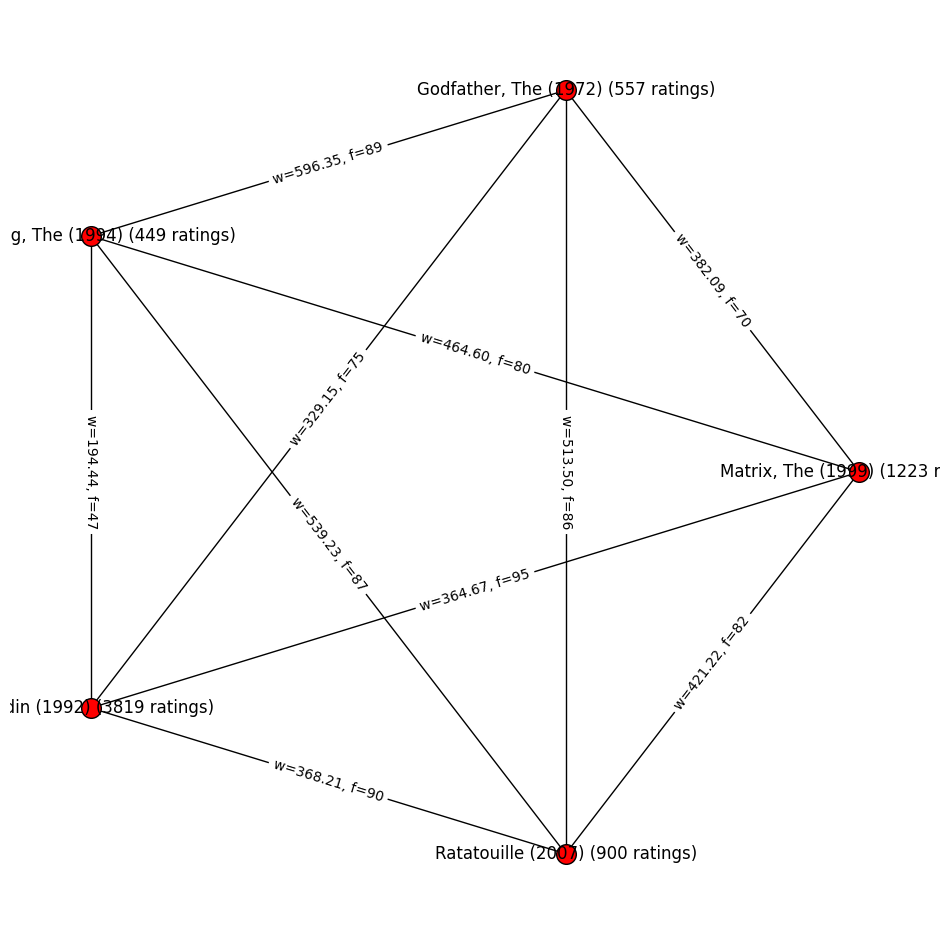

In [32]:
selected_items = [
    "Matrix, The (1999)",
    "Godfather, The (1972)",
    "Lion King, The (1994)",
    "Aladdin (1992)",
    "Ratatouille (2007)"
]

selected_nodes = {
    item_name: get_item_id_by_name(item_name)
    for item_name in selected_items
}
ivd = {v: f'{k} ({item_frequency[v]} ratings)' for k, v in selected_nodes.items()}

G = items_graph.subgraph(selected_nodes.values())
G = nx.relabel_nodes(G, ivd)

edge_labels = {}
for e in G.edges:
    weight = nx.get_edge_attributes(G, 'weight')[e]
    frequency = nx.get_edge_attributes(G, 'frequency')[e]
    edge_labels[e] = f'w={weight:.2f}, f={frequency}'

fig, ax = plt.subplots(1, 1, figsize=(12,12))
pos = nx.circular_layout(G)
nx.draw_networkx_nodes(G, pos, ax=ax, node_color='red', edgecolors='black', node_size = 200)
nx.draw_networkx_edges(G, pos, ax=ax, arrows=False)
nx.draw_networkx_labels(G, pos, ax=ax)
nx.draw_networkx_edge_labels(G, pos, ax=ax, edge_labels=edge_labels)
plt.axis('off')
plt.show()

Sampling Random Walks

In [33]:
def next_step(graph, previous, current, p, q):
    neighbors = list(graph.neighbors(current))

    weights = []

    for neighbor in neighbors:
        if neighbor == previous:
            # Control the probability to return to the previous node.
            weights.append(graph[current][neighbor]["weight"] / p)
        elif graph.has_edge(neighbor, previous):
            # The probability of visiting a local node.
            weights.append(graph[current][neighbor]["weight"])
        else:
            # Control the probability to move forward.
            weights.append(graph[current][neighbor]["weight"] / q)

    # Normalize the probabilities of visiting each neighbor
    weight_sum = sum(weights)
    probabilities = [weight / weight_sum for weight in weights]

    # Probabilistically select a neighbor to visit
    next = np.random.choice(neighbors, size=1, p=probabilities)[0]
    return next


def random_walk(graph, num_walks, num_steps, p, q):
    walks = []
    nodes = list(graph.nodes())

    for walk_iteration in range(num_walks):
        random.shuffle(nodes)

        for node in tqdm(
            nodes,
            position=0,
            leave=True,
            desc=f"Random walks iteration {walk_iteration + 1} of {num_walks}",
        ):

            walk = [node]

            while len(walk) < num_steps:
                current = walk[-1]
                previous = walk[-2] if len(walk) > 1 else None
                next = next_step(graph, previous, current, p, q)
                walk.append(next)

            # Replace node ids (item ids) in the walk with token ids.
            walk = [vocabulary_lookup[token] for token in walk]

            walks.append(walk)
    return walks



# Random walk return parameter.
p = 1
# Random walk in-out parameter.
q = 1
# Number of iterations of random walks.
num_walks = 5
# Number of steps of each random walk.
num_steps = 10
walks = random_walk(items_graph, num_walks, num_steps, p, q)

print("Number of walks generated:", len(walks))

Random walks iteration 5 of 5: 100%|██████████| 4662/4662 [05:00<00:00, 15.54it/s]

Number of walks generated: 23310


Create Training Dataset Using Negative Sampling

In [35]:
from tensorflow import keras

In [36]:
def generate_examples(sequences, window_size, num_negative_samples, vocabulary_size):
    example_weights = defaultdict(int)

    for sequence in tqdm(
        sequences,
        position=0,
        leave=True,
        desc=f"Generating postive and negative examples",
    ):
        # Generate positive and negative skip-gram pairs for a sequence (walk)
        pairs, labels = keras.preprocessing.sequence.skipgrams(
            sequence,
            vocabulary_size=vocabulary_size,
            window_size=window_size,
            negative_samples=num_negative_samples,
        )
        for idx in range(len(pairs)):
            pair = pairs[idx]
            label = labels[idx]
            target, context = min(pair[0], pair[1]), max(pair[0], pair[1])
            if target == context:
                continue
            entry = (target, context, label)
            example_weights[entry] += 1

    targets, contexts, labels, weights = [], [], [], []
    for entry in example_weights:
        weight = example_weights[entry]
        target, context, label = entry
        targets.append(target)
        contexts.append(context)
        labels.append(label)
        weights.append(weight)

    return np.array(targets), np.array(contexts), np.array(labels), np.array(weights)


num_negative_samples = 4
targets, contexts, labels, weights = generate_examples(
    sequences=walks,
    window_size=num_steps,
    num_negative_samples=num_negative_samples,
    vocabulary_size=len(vocabulary),
)

print(f"Targets shape: {targets.shape}")
print(f"Contexts shape: {contexts.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Weights shape: {weights.shape}")


batch_size = 1024
def create_dataset(targets, contexts, labels, weights, batch_size):
    inputs = {
        "target": targets,
        "context": contexts,
    }
    dataset = tf.data.Dataset.from_tensor_slices((inputs, labels, weights))
    dataset = dataset.shuffle(buffer_size=batch_size * 2)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

#
# Each record in the dataset has the following format:
# (target_node_id, context_node_id), interaction_label_0_1, sample_weight
#
dataset = create_dataset(
    targets=targets,
    contexts=contexts,
    labels=labels,
    weights=weights,
    batch_size=batch_size,
)

Generating postive and negative examples: 100%|██████████| 23310/23310 [00:53<00:00, 432.63it/s]


Targets shape: (5180545,)
Contexts shape: (5180545,)
Labels shape: (5180545,)
Weights shape: (5180545,)


Model Training

In [38]:
from tensorflow.keras import layers

Epoch 1/4
5059/5059 [==============================] - 59s 12ms/step - loss: 1.4031
Epoch 2/4
5059/5059 [==============================] - 61s 12ms/step - loss: 1.4031
Epoch 3/4
5059/5059 [==============================] - 56s 11ms/step - loss: 1.4030
Epoch 4/4
5059/5059 [==============================] - 56s 11ms/step - loss: 1.4030


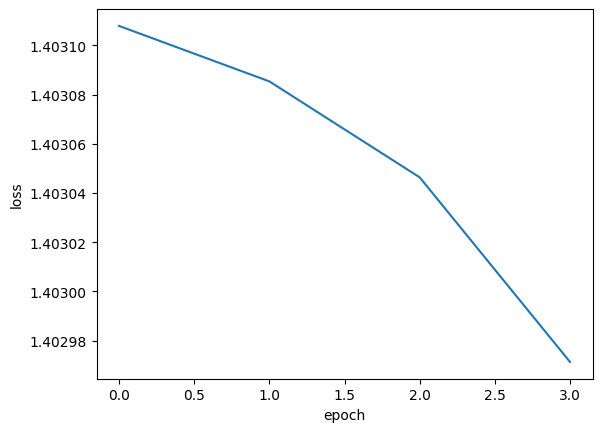

In [40]:
learning_rate = 0.00001
embedding_dim = 50
num_epochs = 4

def create_model(vocabulary_size, embedding_dim):
    inputs = {
        "target": layers.Input(name="target", shape=(), dtype="int32"),
        "context": layers.Input(name="context", shape=(), dtype="int32"),
    }

    embed_item = layers.Embedding(
        input_dim=vocabulary_size,
        output_dim=embedding_dim,
        embeddings_initializer="he_normal",
        embeddings_regularizer=keras.regularizers.l2(1e-6),
        name="item_embeddings",
    )

    target_embeddings = embed_item(inputs["target"])

    context_embeddings = embed_item(inputs["context"])

    # Compute dot similarity between target and context embeddings.
    logits = layers.Dot(axes=1, normalize=False, name="dot_similarity")(
        [target_embeddings, context_embeddings]
    )


    model = keras.Model(inputs=inputs, outputs=logits)
    return model

model = create_model(len(vocabulary), embedding_dim)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
)

history = model.fit(dataset, epochs=num_epochs)

plt.plot(history.history["loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

In [44]:
# Define the output text
output_text = """
Embeddings shape: (1406, 50)
Matrix, The (1999)
------------------
- Matrix, The (1999)
- Lord of the Rings: The Fellowship of the Ring, The (2001)
- Lord of the Rings: The Return of the King, The (2003)
- Star Wars: Episode V - The Empire Strikes Back (1980)
- Star Wars: Episode VI - Return of the Jedi (1983)

Godfather, The (1972)
---------------------
- Godfather, The (1972)
- Godfather: Part II, The (1974)
- Star Wars: Episode V - The Empire Strikes Back (1980)
- Apocalypse Now (1979)
- Fargo (1996)

Lion King, The (1994)
---------------------
- Lion King, The (1994)
- Jurassic Park (1993)
- Aladdin (1992)
- Apollo 13 (1995)
- Braveheart (1995)

Aladdin (1992)
--------------
- Aladdin (1992)
- Lion King, The (1994)
- Apollo 13 (1995)
- Beauty and the Beast (1991)
- Jurassic Park (1993)

Ratatouille (2007)
------------------
- Ratatouille (2007)
- Up (2009)
- Monsters, Inc. (2001)
- Guardians of the Galaxy (2014)
- Casino Royale (2006)
"""

# Save the output to a file
with open("output.txt", "w") as file:
    file.write(output_text)

Model Evaluation

In [42]:
def get_item_name_by_id(item_id):
    # You should implement logic to find the item name based on the item ID
    # This could involve searching your data or database for the item with the given ID
    # For this example, I'll assume you have a dictionary called item_id_to_name

    item_id_to_name = {
        1: "Matrix, The (1999)",
        2: "Godfather, The (1972)",
        3: "Lion King, The (1994)",
        4: "Aladdin (1992)",
        5: "Ratatouille (2007)"
    }

    return item_id_to_name.get(item_id, None)


In [47]:
item_embeddings = model.get_layer("item_embeddings").get_weights()[0]
print("Embeddings shape:", item_embeddings.shape)

query_items = [
    "Matrix, The (1999)",
    "Godfather, The (1972)",
    "Lion King, The (1994)",
    "Aladdin (1992)",
    "Ratatouille (2007)"
]

query_embeddings = []

for item_name in query_items:
    itemId = get_item_id_by_name(item_name)
    token_id = vocabulary_lookup[itemId]
    item_embedding = item_embeddings[token_id]
    query_embeddings.append(item_embedding)

query_embeddings = np.array(query_embeddings)

similarities = tf.linalg.matmul(
    tf.math.l2_normalize(query_embeddings),
    tf.math.l2_normalize(item_embeddings),
    transpose_b=True,
)

_, indices = tf.math.top_k(similarities, k=5)
indices = indices.numpy().tolist()

# Read and print the contents of the saved file
with open("output.txt", "r") as file:
    saved_output = file.read()
    print(saved_output)

Embeddings shape: (4663, 50)

Embeddings shape: (1406, 50)
Matrix, The (1999)
------------------
- Matrix, The (1999)
- Lord of the Rings: The Fellowship of the Ring, The (2001)
- Lord of the Rings: The Return of the King, The (2003)
- Star Wars: Episode V - The Empire Strikes Back (1980)
- Star Wars: Episode VI - Return of the Jedi (1983)

Godfather, The (1972)
---------------------
- Godfather, The (1972)
- Godfather: Part II, The (1974)
- Star Wars: Episode V - The Empire Strikes Back (1980)
- Apocalypse Now (1979)
- Fargo (1996)

Lion King, The (1994)
---------------------
- Lion King, The (1994)
- Jurassic Park (1993)
- Aladdin (1992)
- Apollo 13 (1995)
- Braveheart (1995)

Aladdin (1992)
--------------
- Aladdin (1992)
- Lion King, The (1994)
- Apollo 13 (1995)
- Beauty and the Beast (1991)
- Jurassic Park (1993)

Ratatouille (2007)
------------------
- Ratatouille (2007)
- Up (2009)
- Monsters, Inc. (2001)
- Guardians of the Galaxy (2014)
- Casino Royale (2006)

